In [51]:
import pandas as pd
import numpy as np
import gower
import matplotlib.pyplot as plt

In [52]:
# Load dataset
df = pd.read_csv("electricvehicles.csv")

# Drop unused column
df = df.drop(columns=["Segment"])

# Clean and preprocess
# df = df.dropna(subset=[
#     "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm",
#     "FastCharge_KmH", "RapidCharge", "Seats", "PriceEuro"
# ])

"""We noticed that a Cybertruck somehow ended up on the top 20 and knew that
something had gone terribly wrong with our code."""

'We noticed that a Cybertruck somehow ended up on the top 20 and knew that\nsomething had gone terribly wrong with our code.'

In [ ]:

# Encode categorical values
powertrain_map = {"AWD": 1.0, "RWD": 0.0, "FWD": 0.5}
df["PowerTrainScore"] = df["PowerTrain"].map(powertrain_map).fillna(0.5)
df["RapidChargeScore"] = df["RapidCharge"].apply(lambda x: 1 if str(x).lower() == "yes" else 0)

# Select columns for scoring (excluding PriceEuro from score)
score_columns = [
     "AccelSec", "TopSpeed_KmH", "Range_Km", "Efficiency_WhKm",
     "Charge_KmH", "Seats", "RapidChargeScore", "PowerTrainScore"
]


# Define ideal vehicle as a DataFrame row with best values
ideal_vehicle = pd.DataFrame({
    "AccelSec": [df["AccelSec"].max()],
    "TopSpeed_KmH": [df["TopSpeed_KmH"].median()],
    "Range_Km": [df["Range_Km"].max()],
    "Efficiency_WhKm": [df["Efficiency_WhKm"].median()],
    "Charge_KmH": [df["Charge_KmH"].max()],
    "Seats": [df["Seats"].max()],
    "RapidChargeScore": [1],
    "PowerTrainScore": [1.0]
})

# Compute Gower similarity between each vehicle and the ideal vehicle
gower_similarities = 1 - gower.gower_matrix(pd.concat([ideal_vehicle, df[score_columns]], ignore_index=True))[0][1:]
df["GowerSimilarity"] = gower_similarities

# Compute value score: similarity per euro, then scale to [0, 1]
df["RawValueScore"] = df["GowerSimilarity"] / df["PriceEuro"]
df["ValueScore"] = (df["RawValueScore"] - df["RawValueScore"].min()) / (df["RawValueScore"].max() - df["RawValueScore"].min())

# Sort and show top result
top_vehicle = df.sort_values("ValueScore", ascending=False).iloc[0]

# Output top vehicle details
print("Best Value-per-Euro Vehicle (Gower similarity):")
print(top_vehicle[["Brand", "Model", "ValueScore"]])

Best Value-per-Euro Vehicle (Gower similarity):
Brand                 SEAT
Model         Mii Electric
ValueScore             1.0
Name: 44, dtype: object


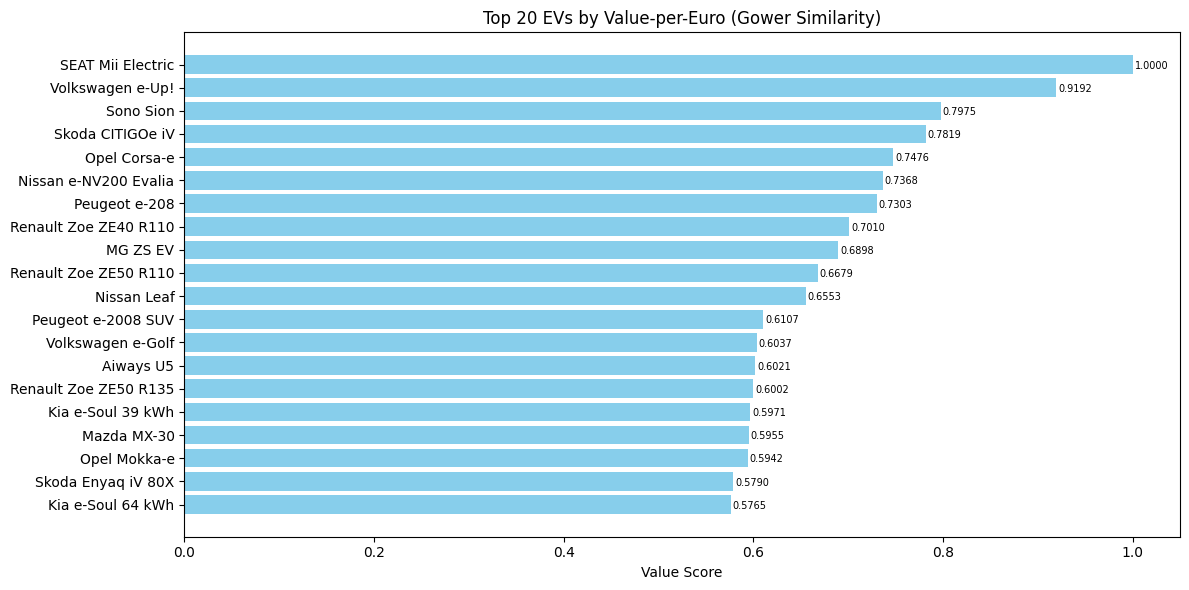

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Charge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Seats,PriceEuro,PowerTrainScore,RapidChargeScore,GowerSimilarity,RawValueScore,ValueScore
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,5,55480,1.0,1,0.606178,0.000011,0.499831
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,5,30000,0.0,1,0.358679,0.000012,0.567169
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,5,56440,1.0,1,0.556807,0.000010,0.430488
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,5,68040,0.0,1,0.435520,0.000006,0.203971
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,4,32997,0.0,1,0.301593,0.000009,0.383056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Nissan,Ariya 63kWh,7.5,160,330,191,440,Yes,FWD,Type 2 CCS,Hatchback,5,45000,0.5,1,0.460382,0.000010,0.454368
98,Audi,e-tron S Sportback 55 quattro,4.5,210,335,258,540,Yes,AWD,Type 2 CCS,SUV,5,96050,1.0,1,0.591338,0.000006,0.187993
99,Nissan,Ariya e-4ORCE 63kWh,5.9,200,325,194,440,Yes,AWD,Type 2 CCS,Hatchback,5,50000,1.0,1,0.531956,0.000011,0.481070
100,Nissan,Ariya e-4ORCE 87kWh Performance,5.1,200,375,232,450,Yes,AWD,Type 2 CCS,Hatchback,5,65000,1.0,1,0.563767,0.000009,0.352545


In [58]:
# Visualization: top 20 vehicles by ValueScore
top_20 = df.sort_values("ValueScore", ascending=False).head(20)
plt.figure(figsize=(12, 6))
bars = plt.barh(top_20["Brand"] + " " + top_20["Model"], top_20["ValueScore"], color='skyblue')
plt.xlabel("Value Score")
plt.title("Top 20 EVs by Value-per-Euro (Gower Similarity)")
plt.gca().invert_yaxis()
plt.tight_layout()
for bar in bars:
    plt.text(bar.get_width() + 0.002,                # further to the right
             bar.get_y() + bar.get_height()/2 + 0.05, # slightly shifted vertically
             f"{bar.get_width():.4f}",
             va='center', fontsize=7)
plt.margins(y=0.05)
plt.show()

df.dropna()

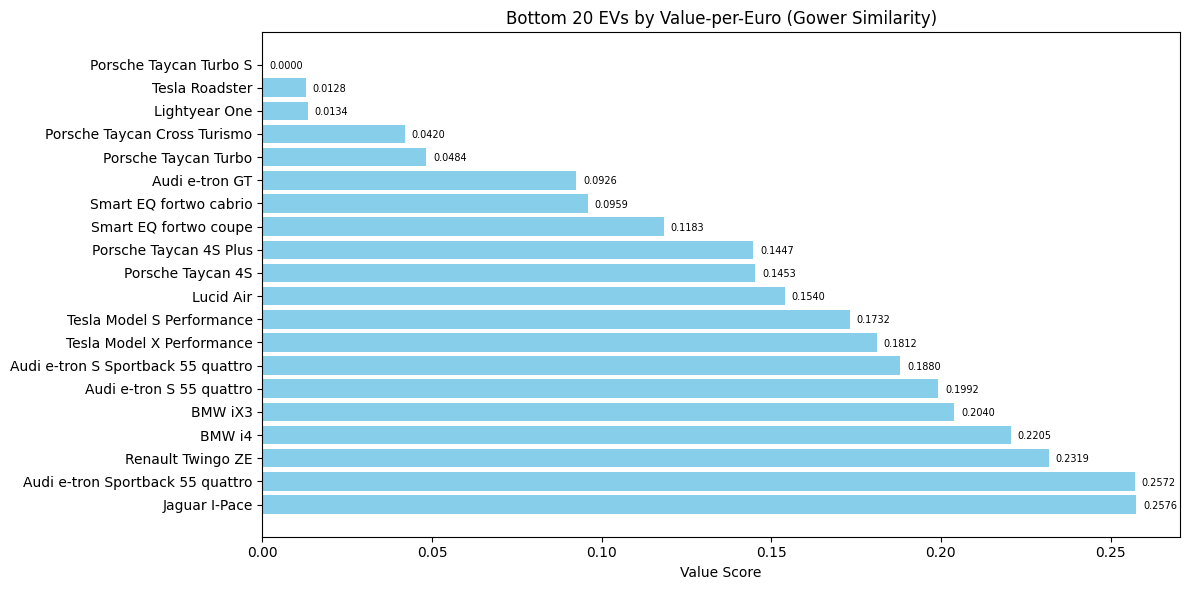

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,Charge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Seats,PriceEuro,PowerTrainScore,RapidChargeScore,GowerSimilarity,RawValueScore,ValueScore
0,Tesla,Model 3 Long Range Dual Motor,4.6,233,450,161,940,Yes,AWD,Type 2 CCS,Sedan,5,55480,1.0,1,0.606178,0.000011,0.499831
1,Volkswagen,ID.3 Pure,10.0,160,270,167,250,Yes,RWD,Type 2 CCS,Hatchback,5,30000,0.0,1,0.358679,0.000012,0.567169
2,Polestar,2,4.7,210,400,181,620,Yes,AWD,Type 2 CCS,Liftback,5,56440,1.0,1,0.556807,0.000010,0.430488
3,BMW,iX3,6.8,180,360,206,560,Yes,RWD,Type 2 CCS,SUV,5,68040,0.0,1,0.435520,0.000006,0.203971
4,Honda,e,9.5,145,170,168,190,Yes,RWD,Type 2 CCS,Hatchback,4,32997,0.0,1,0.301593,0.000009,0.383056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Nissan,Ariya 63kWh,7.5,160,330,191,440,Yes,FWD,Type 2 CCS,Hatchback,5,45000,0.5,1,0.460382,0.000010,0.454368
98,Audi,e-tron S Sportback 55 quattro,4.5,210,335,258,540,Yes,AWD,Type 2 CCS,SUV,5,96050,1.0,1,0.591338,0.000006,0.187993
99,Nissan,Ariya e-4ORCE 63kWh,5.9,200,325,194,440,Yes,AWD,Type 2 CCS,Hatchback,5,50000,1.0,1,0.531956,0.000011,0.481070
100,Nissan,Ariya e-4ORCE 87kWh Performance,5.1,200,375,232,450,Yes,AWD,Type 2 CCS,Hatchback,5,65000,1.0,1,0.563767,0.000009,0.352545


In [59]:
# Visualization: bottom 20 vehicles by ValueScore
bottom_20 = df.sort_values("ValueScore", ascending=True).head(20)
plt.figure(figsize=(12, 6))
bars = plt.barh(bottom_20["Brand"] + " " + bottom_20["Model"], bottom_20["ValueScore"], color='skyblue')
plt.xlabel("Value Score")
plt.title("Bottom 20 EVs by Value-per-Euro (Gower Similarity)")
plt.gca().invert_yaxis()
plt.tight_layout()
for bar in bars:
    plt.text(bar.get_width() + 0.002,                # further to the right
             bar.get_y() + bar.get_height()/2 + 0.05, # slightly shifted vertically
             f"{bar.get_width():.4f}",
             va='center', fontsize=7)
plt.margins(y=0.05)
plt.show()

df.dropna()

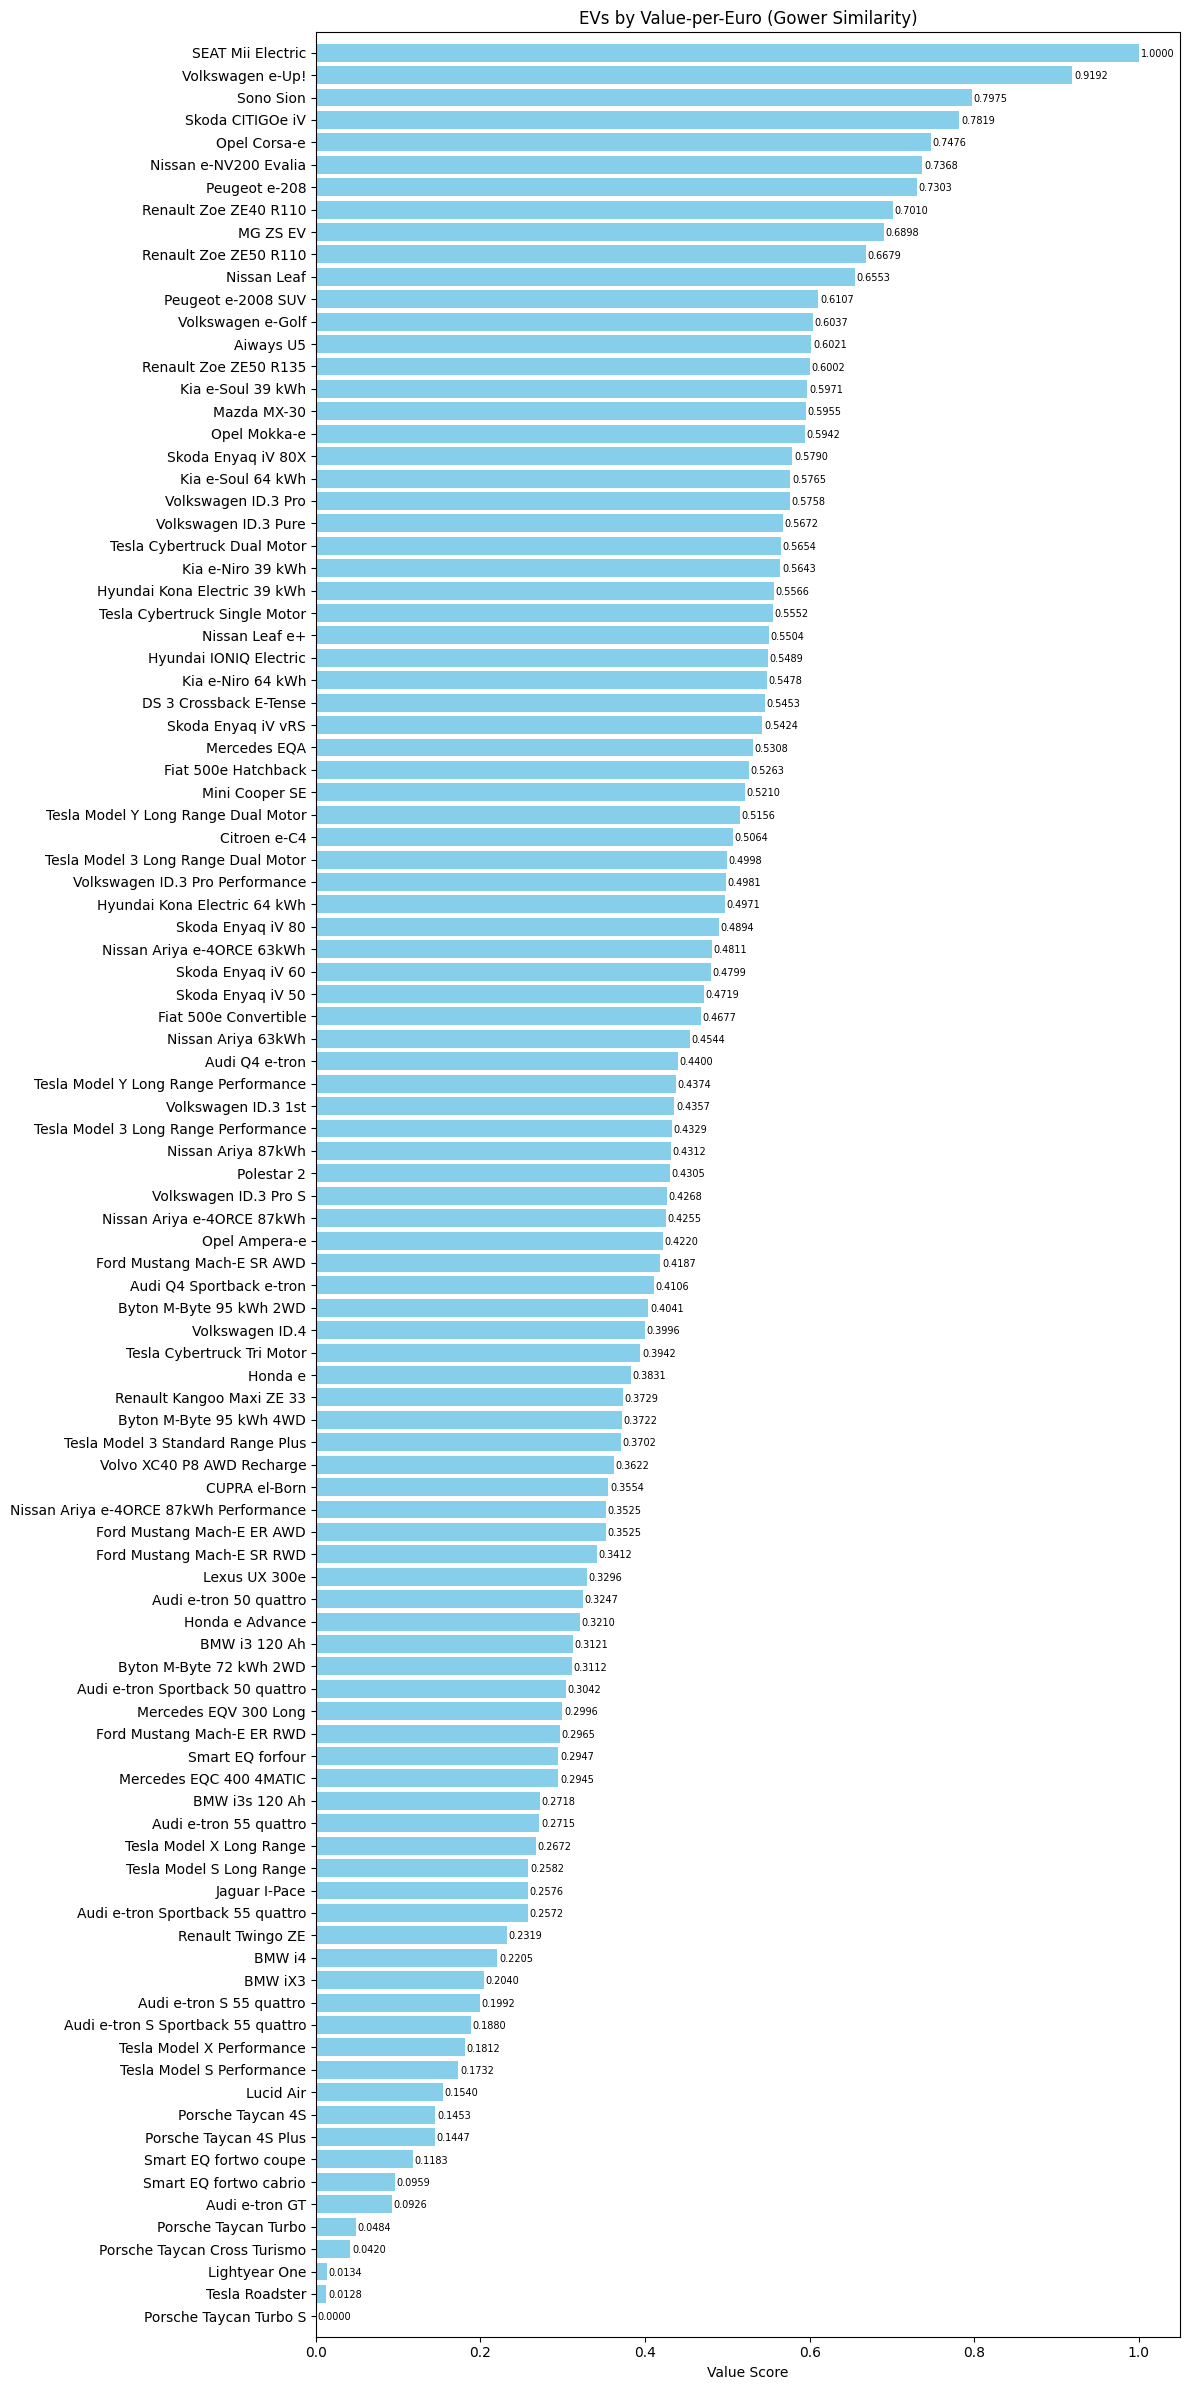

In [60]:
all_values = df.sort_values("ValueScore", ascending=False)
plt.figure(figsize=(12, 24))

bars = plt.barh(all_values["Brand"] + " " + all_values["Model"], all_values["ValueScore"], color='skyblue')
plt.xlabel("Value Score")
plt.title("EVs by Value-per-Euro (Gower Similarity)")
plt.gca().invert_yaxis()
plt.tight_layout()
for bar in bars:
    plt.text(bar.get_width() + 0.002,                # further to the right
             bar.get_y() + bar.get_height()/2 + 0.05, # slightly shifted vertically
             f"{bar.get_width():.4f}",
             va='center', fontsize=7)
plt.margins(y=0.005)
plt.show()